In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr
%load_ext rpy2.ipython



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [134]:
df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()
#df = pd.read_pickle('data/prop_data_2_ni_NEST.pkl').drop_duplicates()

In [135]:
# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'MOD'

time_win = 2 #h
max_gap = 10 #s

df_filt = df.loc[(df.time_win==3600 * time_win) & 
                 (df.max_gap==max_gap) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]
df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
df_filt = df_filt.sort_values(['rep','h'])

rep_to_colony = {i: i for i in range(57)}
#df_filt.insert(5, 'colony', [rep_to_colony[j] for j in df_filt.rep])

# Export dataframe for stats
df_filt.to_csv('NTM_df_stats.csv')
df_filt


,rep,exp,start,time_win,h,max_gap,GC,ants,partition,MOD,...,wDEN,DIA,wDIA,RAD,wRAD,DEH,cDEH,wDEH,cwDEH,CLS
99,14,MODa,2021-09-13 09:00:00,7200,9,10,138,176,46,0.484788,...,0.002732,3,2.693141,2,2.0,38.143392,29.764288,3462.34201,3335.990926,0.003648
142,14,MODb,2021-09-11 09:00:00,7200,9,10,150,185,42,0.39219,...,0.003382,4,0.975292,2,0.5,42.018909,32.301568,3999.923996,3735.753343,0.004763
100,14,MODa,2021-09-13 11:00:00,7200,11,10,139,176,44,0.381884,...,0.002633,3,1.0128,2,0.75,36.980548,28.860467,3186.488377,3024.561888,0.004062
143,14,MODb,2021-09-11 11:00:00,7200,11,10,157,185,34,0.354229,...,0.00258,4,1.737667,2,1.5,41.623603,35.491943,3122.422611,3005.558343,0.0059
101,14,MODa,2021-09-13 13:00:00,7200,13,10,153,176,31,0.43065,...,0.003128,4,0.49175,2,0.333333,38.199367,32.210071,3704.784616,3619.720329,0.004516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,54,MODb,2021-12-18 15:00:00,7200,15,10,152,162,16,0.365338,...,0.005733,4,2.385114,2,2.0,37.853408,33.443331,4389.518853,4175.977309,0.008777
3457,54,MODa,2021-12-20 17:00:00,7200,17,10,145,158,19,0.34688,...,0.005107,4,9.0,2,6.0,38.853325,32.421221,4206.320451,4003.018845,0.009312
3500,54,MODb,2021-12-18 17:00:00,7200,17,10,151,162,18,0.380658,...,0.005526,3,6.340784,2,6.0,35.373143,30.756526,4348.481854,4132.718508,0.004465
3458,54,MODa,2021-12-20 19:00:00,7200,19,10,146,158,19,0.314112,...,0.004855,4,8.040384,2,6.0,37.320146,31.619973,3794.521514,3592.017763,0.010423


In [136]:
%%R -i time_win -o prop_list -o pv_adj 

# -----------------------------
# Linear Mixed Effects Model (R)
# -----------------------------
rm(list=ls())
library(lme4)
library(car)

prop_list <- c('cMOD','wDIA','cwDEH','wDEN')
dat <- read.csv("NTM_df_stats.csv",header=T,stringsAsFactors = F)
  # list of properties for the LMER test
pv_list <- integer(0)

print(dat$head)
if (dat$time_win[1] == 12*3600){rf <- ' ~ exp +(1|rep)'}
    else{rf <- ' ~ exp +(1|rep)+(1|h)'}

for (prop in prop_list){
    model <- lmer(formula(paste(prop,rf)), data = dat)
    print(summary(model))
    pv_list <- c(pv_list, as.numeric(Anova(model)["exp","Pr(>Chisq)"]))
}

pv_adj <- p.adjust(pv_list, method="BH")
names(pv_adj) <- prop_list

print(pv_adj)

NULL
Linear mixed model fit by REML ['lmerMod']
Formula: cMOD ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: -390.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5109 -0.5332 -0.0057  0.5882  2.6915 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep      (Intercept) 0.001265 0.03557 
 h        (Intercept) 0.000232 0.01523 
 Residual             0.002220 0.04712 
Number of obs: 132, groups:  rep, 11; h, 6

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.352847   0.013687  25.780
expMODb     0.011985   0.008203   1.461

Correlation of Fixed Effects:
        (Intr)
expMODb -0.300


R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: wDIA ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 597.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8851 -0.6430 -0.3748  0.1286  4.2640 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep      (Intercept) 0.000    0.000   
 h        (Intercept) 0.000    0.000   
 Residual             5.441    2.333   
Number of obs: 132, groups:  rep, 11; h, 6

Fixed effects:
            Estimate Std. Error t value
(Intercept)   2.2075     0.2871   7.688
expMODb      -0.1432     0.4061  -0.353

Correlation of Fixed Effects:
        (Intr)
expMODb -0.707
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular



R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: cwDEH ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 1960.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2606 -0.6993 -0.1389  0.6537  2.6653 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep      (Intercept) 519994   721.1   
 h        (Intercept)      0     0.0   
 Residual             145813   381.9   
Number of obs: 132, groups:  rep, 11; h, 6

Fixed effects:
            Estimate Std. Error t value
(Intercept)  3689.81     222.44  16.588
expMODb       238.34      66.47   3.586

Correlation of Fixed Effects:
        (Intr)
expMODb -0.149
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular

Linear mixed model fit by REML ['lmerMod']
Formula: wDEN ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: -1583.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.12040 -0.61787 -0.02866  0.68212  2.16141 

Ran

In [137]:
pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}
pv_dict

{'cMOD': 0.28794426424560676,
 'wDIA': 0.7243248306290954,
 'cwDEH': 0.0013453590342296102,
 'wDEN': 0.7243248306290954}

/tmp/ipykernel_5468/3052687015.py:32: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  stat_sign = '*' + (pv_dict[p]<=0.01)*'*' + (pv_dict[p]<=0.001)*'*' + (pv_dict[p]<=0.0001)*'*'


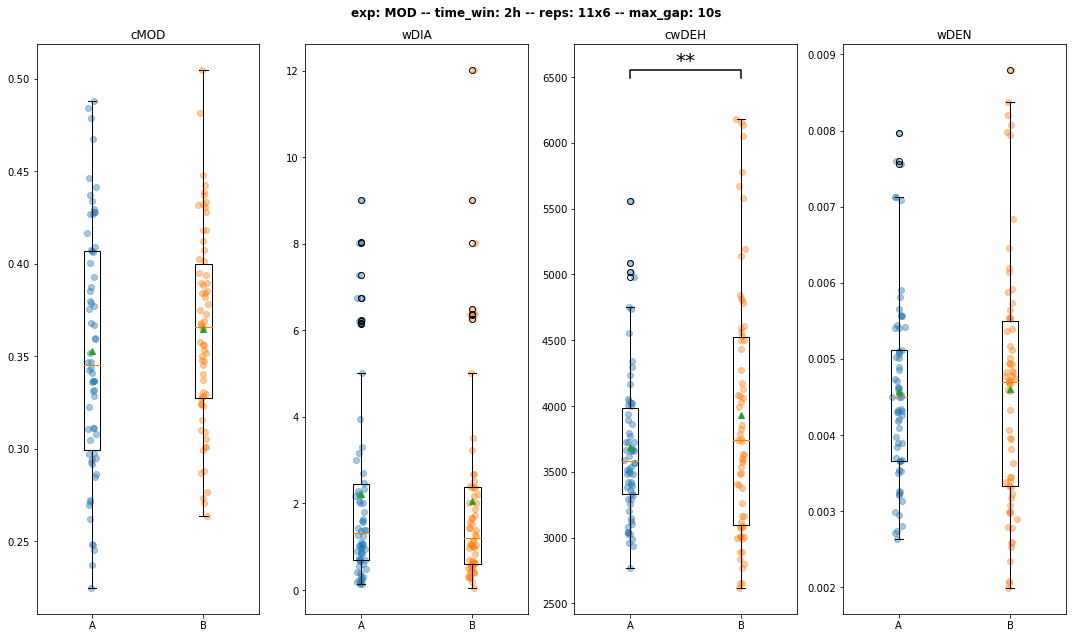

In [138]:
# Raw data specific property
fig, axs = plt.subplots(1, len(prop_list))

for idx_p, p in enumerate(prop_list):

    # dataframe for a-b comparison
    df_ab = pd.DataFrame()
    df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
    df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
    df_ab


    # Plotting
    vals, names, xs = [],[],[]
    for i, col in enumerate(df_ab.columns):
        vals.append(df_ab[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.02, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted


    box_plot = axs[idx_p].boxplot(vals, labels=names, showmeans=True)
    for x, val in zip(xs, vals):
        axs[idx_p].scatter(x, val, alpha=0.4)

    means = df_ab.mean()
    stds =  df_ab.std()
    
    axs[idx_p].set_title(p)
    
    # statistical annotation
    if pv_dict[p]<=0.05:
        stat_sign = '*' + (pv_dict[p]<=0.01)*'*' + (pv_dict[p]<=0.001)*'*' + (pv_dict[p]<=0.0001)*'*'
        x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        mm =np.max(df_ab.max())
        y, h, col = 1.05*mm, 0.01*mm, 'k'
        axs[idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        axs[idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=20)

fig = plt.suptitle('exp: ' + exp + 
                    ' -- time_win: ' + str(time_win) + 'h'
                    ' -- reps: ' + str(int(len(df_ab)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                    ' -- max_gap: ' + str(max_gap) + 's',
                   fontweight="bold")
plt.tight_layout()
plt.show()

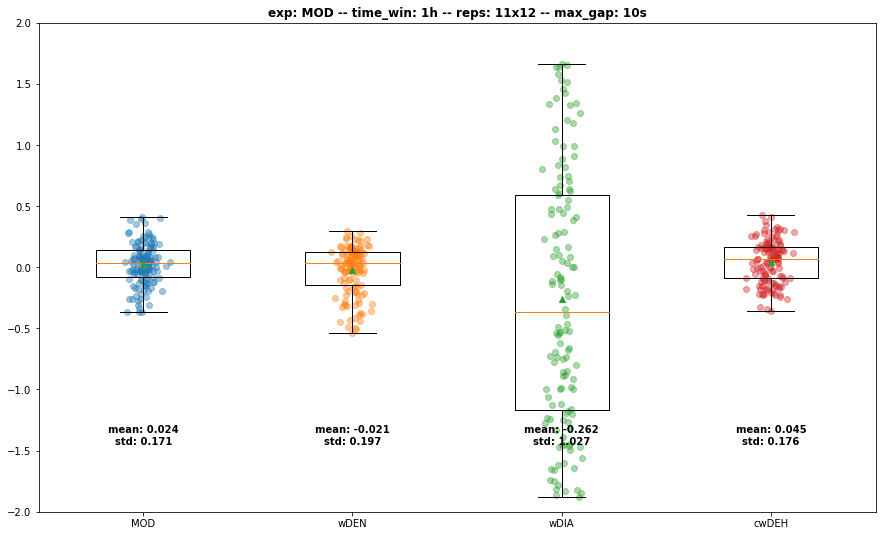

In [119]:
#===== RELATIVE DIFFERENCE =====


# ---- dataframe of relative difference---- 
p = ['MOD', 'wDEN', 'wDIA', 'cwDEH']
df_rd = (df_filt[p].diff()/df_filt[p].rolling(2).mean()).iloc[1::2]
df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

vals, names, xs = [],[],[]
for i, col in enumerate(df_rd[p].columns):
    vals.append(df_rd[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df_rd[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

plt.figure()
box_plot = plt.boxplot(vals, labels=names, showmeans=True)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4)

means = df_rd[p].mean()
stds =  df_rd[p].std()

for xtick in range(len(p)):
    plt.text(xtick+1,-1.35, 'mean: {:.3f}'.format(means[xtick]), 
              horizontalalignment='center',size='medium',color='k',weight='semibold')
    plt.text(xtick+1,-1.45, 'std: {:.3f}'.format(stds[xtick]), 
                  horizontalalignment='center',size='medium',color='k',weight='semibold')

plt.ylim([-2,2])
fig = plt.title('exp: ' + exp + 
                ' -- time_win: ' + str(time_win) + 'h'
                ' -- reps: ' + str(int(len(df_rd)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                ' -- max_gap: ' + str(max_gap) + 's',
               fontweight="bold")